# KAN-ODE

## KODE网络训练

### 安装依赖

In [1]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN  

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [3]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  # 用于记录neural_output

    def forward(self, t, y):
        S, I, R= y
        neural_output = self.neural_part(torch.tensor([S,I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  # 记录neural_output
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

### 初始化模型参数

In [4]:
gamma = 0.07
beta = 2 * gamma  #根据实际情况，参数beta是参数gamma的具体倍数
neural_ode_func = EKAN(layers_hidden=[2, 16, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [5]:
intial = 0.  ##时间区间的初始值
last= 120.    ##时间区间的终值
step = 120    ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 生成真实数据

In [6]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R= y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

### 定义损失函数
#### 使用仅与I相关的损失函数

In [7]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

### 定义准确率计算函数
#### 使用仅与I相关的准确率函数

In [8]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

### 定义训练模型
执行模型的训练

In [9]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(5000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

### 进行训练

In [10]:
t, true_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.024868987500667572, Accuracy: 11.67%
Iter 100, Loss: 0.009807946160435677, Accuracy: 6.67%
Iter 200, Loss: 0.004022744484245777, Accuracy: 13.33%
Iter 300, Loss: 0.002270081778988242, Accuracy: 12.50%
Iter 400, Loss: 0.0019231676124036312, Accuracy: 14.17%
Iter 500, Loss: 0.0016454282449558377, Accuracy: 14.17%
Iter 600, Loss: 0.0013844072818756104, Accuracy: 16.67%
Iter 700, Loss: 0.0011399365030229092, Accuracy: 17.50%
Iter 800, Loss: 0.000914558011572808, Accuracy: 19.17%
Iter 900, Loss: 0.000711764907464385, Accuracy: 21.67%
Iter 1000, Loss: 0.0005349871353246272, Accuracy: 23.33%
Iter 1100, Loss: 0.0003867124323733151, Accuracy: 28.33%
Iter 1200, Loss: 0.00026780078769661486, Accuracy: 34.17%
Iter 1300, Loss: 0.0001771042007021606, Accuracy: 40.83%
Iter 1400, Loss: 0.00011160728899994865, Accuracy: 50.00%
Iter 1500, Loss: 6.695874617435038e-05, Accuracy: 70.00%
Iter 1600, Loss: 3.829423076240346e-05, Accuracy: 92.50%
Iter 1700, Loss: 2.0982448404538445e-05, Accurac

#### 定义差分机计算公式

In [11]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

In [12]:
true_y[:,2] = forword_CF(true_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_2926140/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


### 将最终数据保存至Excel

In [13]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
}
df = pd.DataFrame(data)


### 保存成Excel文件

In [14]:
df.to_excel('result/KAN/kan2-16-1.xlsx', index=False)

### 绘制结果并将图片结果保存

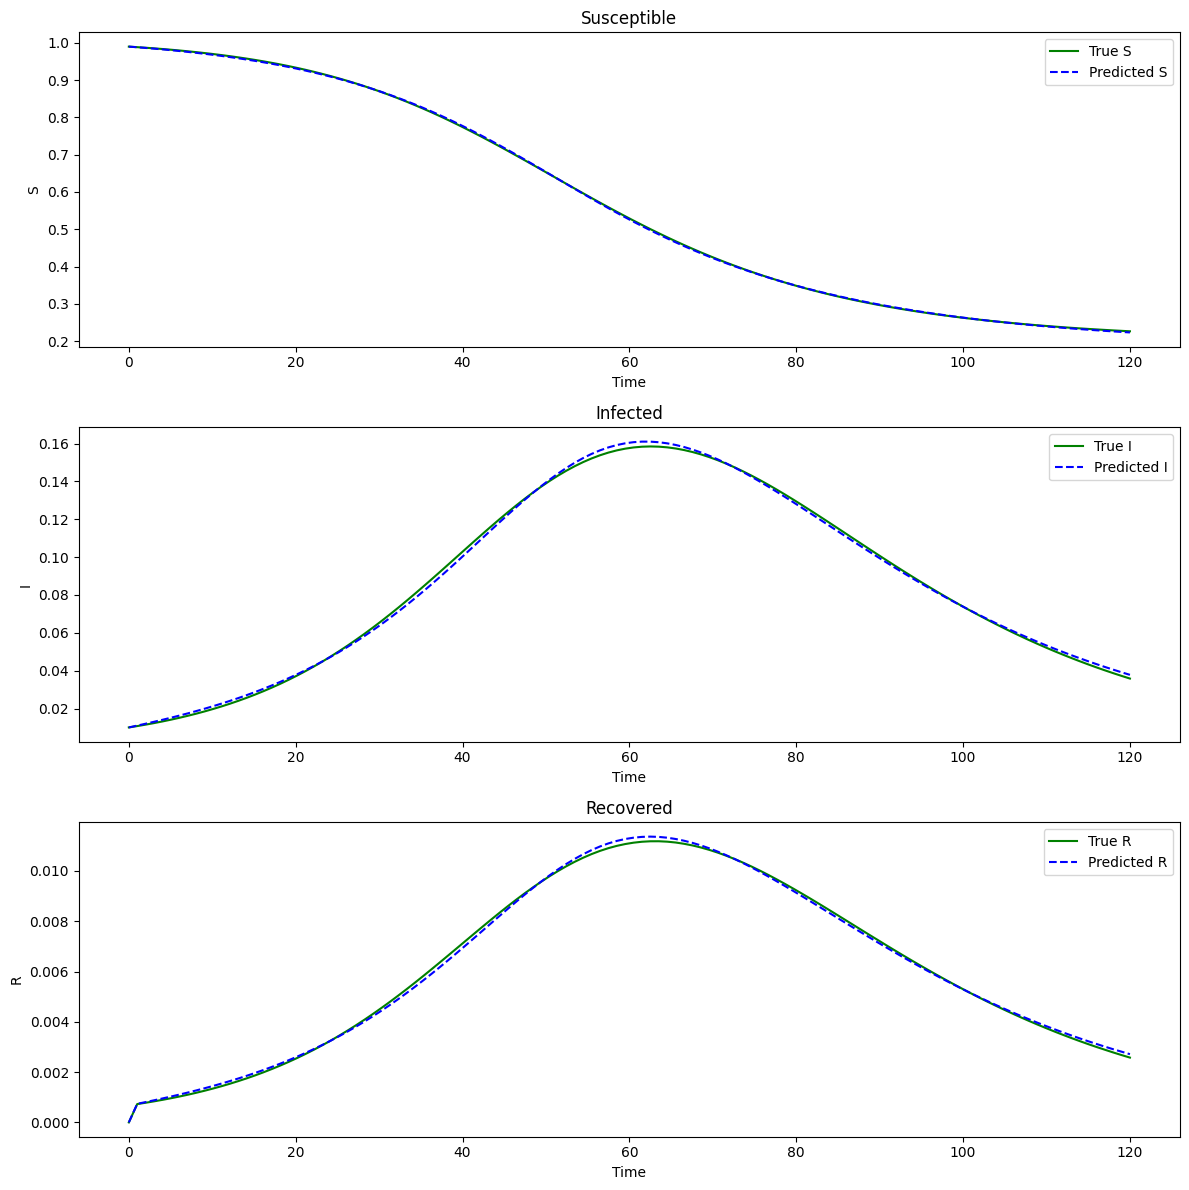

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/KAN/kan2-16-1_SIR.png')
plt.show()
